In [1]:
from pgnano.stats_analysis.primitives import PGPoreType
from pgnano.stats_analysis.jupyter_data_preparation import flatten_sample_data
from functools import partial
from pgnano.stats_analysis.coding_analysis_scripts import *
from scipy.stats import geom, halfnorm, norm
from scipy.linalg import lstsq
from scipy.fft import fft
from itertools import repeat
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import statistics
from math import sqrt

In [2]:
signal_data, chunk_data = flatten_sample_data(PGPoreType.P10_4_1,100)
error = transform_signal_to_error(signal_data[0])
code = transform_error_to_code(error)
start = 250
size = 250
limit = start + size

['/data/datananoraw/data_analysis/10_4_1/2d6ce589-PAG70058_pass_90cff557_229fb1c2_1643.pod5', '/data/datananoraw/data_analysis/10_4_1/58662236-PAG70133_pass_976dfe21_5dadfada_5.pod5', '/data/datananoraw/data_analysis/10_4_1/679e8449-PAG70058_pass_90cff557_229fb1c2_1581.pod5', '/data/datananoraw/data_analysis/10_4_1/7646a9e4-PAG65784_pass_f306681d_16a70748_508.pod5', '/data/datananoraw/data_analysis/10_4_1/889add85-PAG67404_fail_a8a15ce6_4a74c11f_28.pod5', '/data/datananoraw/data_analysis/10_4_1/898fa111-PAG68757_fail_39c39833_26077d5d_167.pod5', '/data/datananoraw/data_analysis/10_4_1/8ba56eeb-PAG65784_pass_f306681d_16a70748_1319.pod5', '/data/datananoraw/data_analysis/10_4_1/a60ded57-PAG65902_pass_96491aed_0156c9a3_1335.pod5', '/data/datananoraw/data_analysis/10_4_1/a7ff4244-PAG68757_pass_39c39833_26077d5d_944.pod5', '/data/datananoraw/data_analysis/10_4_1/af5d6be7-PAG70133_pass_976dfe21_5dadfada_1065.pod5', '/data/datananoraw/data_analysis/10_4_1/c2f433b8-PAG65902_fail_96491aed_0156c

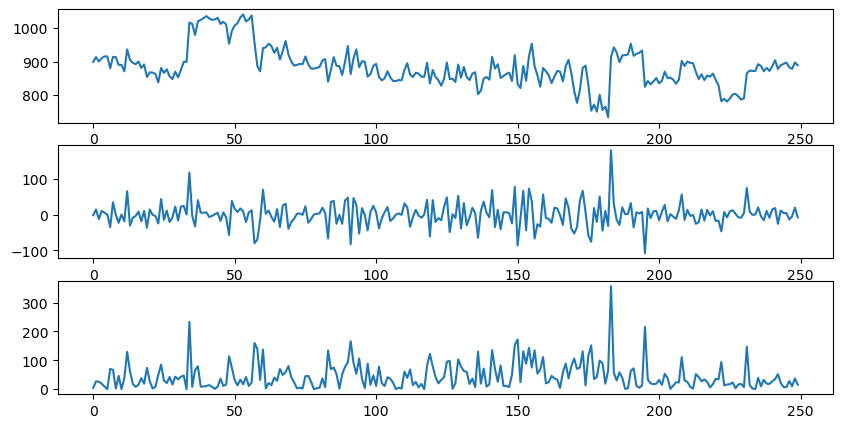

In [3]:
figs, axs = plt.subplots(3,1,figsize=(10, 5))
axs[0].plot(signal_data[0][start:limit])
axs[1].plot(error[start:limit])
axs[2].plot(code[start:limit])

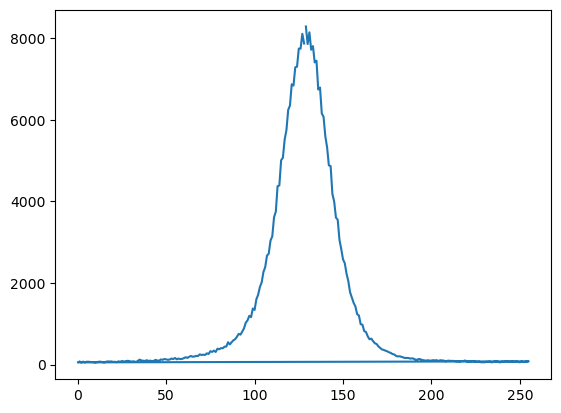

In [4]:
bit = 8
low_histogram_error, high_histogram_error = get_splitted_histograms(error,bit)
xs = range((1 << bit))
xs = np.asarray(xs, dtype=np.uint8) - 127
#std_dev = np.std(circular_error)
#mean = np.mean(circular_error)

#xs_range = np.arange(0,257,1)
#plt.plot(xs_range, norm.pdf(xs_range, mean, std_dev) * len(circular_error))
plt.plot(xs, low_histogram_error)

30.876028061675004
0.002692845534600703


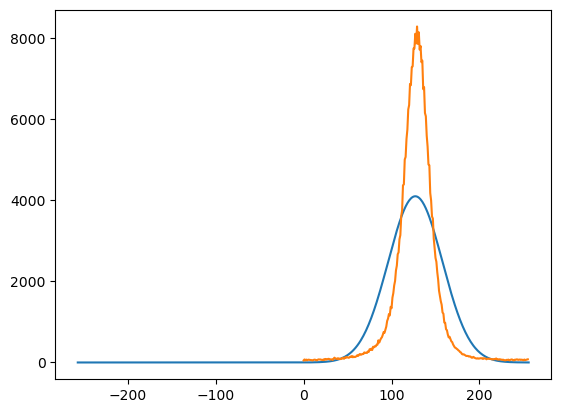

In [5]:
bit = 8
circular_error = error - 127
low_histogram_error, high_histogram_error = get_splitted_histograms(circular_error,bit)
std_dev = np.std(error)
mean = np.mean(error)
print(std_dev)
print(mean)
xs_range = np.arange(-257,257,1)
plt.plot(xs_range, (norm.pdf(xs_range, mean + 127, std_dev)) * len(circular_error))
plt.plot(low_histogram_error)

30.876028061675004
0.002692845534600703


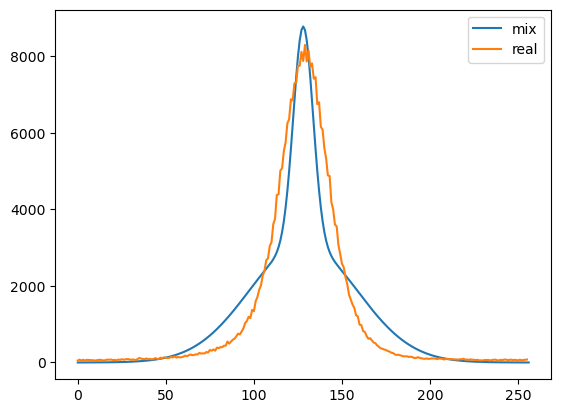

In [6]:
bit = 8
circular_error = error - 127
low_histogram_error, high_histogram_error = get_splitted_histograms(circular_error,bit)
std_dev = np.std(error)
mean = np.mean(error)
print(std_dev)
print(mean)
xs_range = np.arange(0,257,1)
ys_1 = norm.pdf(xs_range, mean + 128, std_dev) * len(circular_error)
ys_2 = norm.pdf(xs_range, mean + 128, sqrt(std_dev)) * len(circular_error)
plt.plot(xs_range, ys_1 * 0.75 + ys_2 * 0.25, label="mix")
plt.plot(low_histogram_error, label="real")
plt.legend()

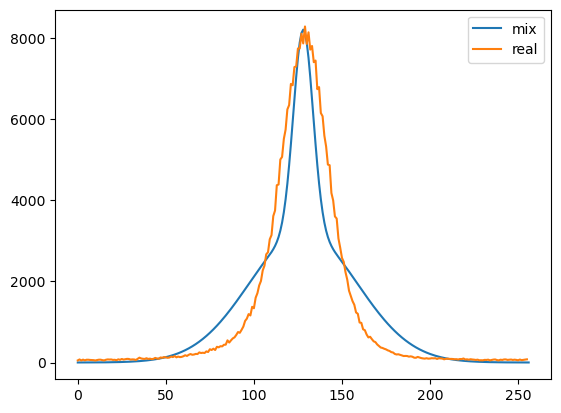

In [7]:
bit = 8
circular_error = error - 127
low_histogram_error, high_histogram_error = get_splitted_histograms(circular_error,bit)
std_dev = np.std(error)
mean = np.mean(error)
xs_range = np.arange(0,257,1)
ys_1 = norm.pdf(xs_range, mean + 128, std_dev)
ys_2 = norm.pdf(xs_range, mean + 128, sqrt(std_dev))
plt.plot(xs_range, (ys_1 * 0.78 + ys_2 * 0.22)*len(error), label="mix")
plt.plot(low_histogram_error, label="real")
plt.legend()

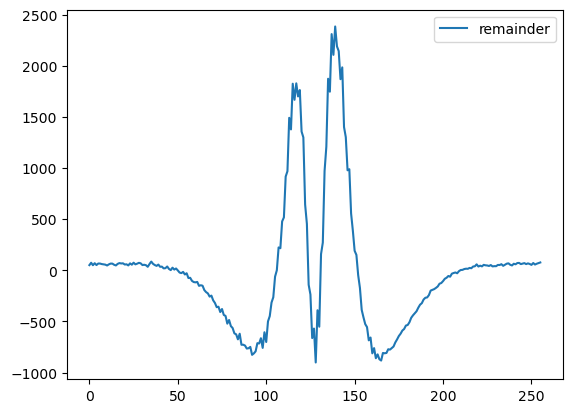

In [8]:
bit = 8
circular_error = error - 127
low_histogram_error, high_histogram_error = get_splitted_histograms(circular_error,bit)
std_dev = np.std(error)
mean = np.mean(error)
xs_range = np.arange(0,256,1)
ys_1 = norm.pdf(xs_range, mean + 128, std_dev)
ys_2 = norm.pdf(xs_range, mean + 128, sqrt(std_dev))
combination = ys_1 * 0.75 + ys_2 * 0.25

plt.plot(low_histogram_error - combination*len(error), label="remainder")
plt.legend()
plt.savefig("FooNormal")

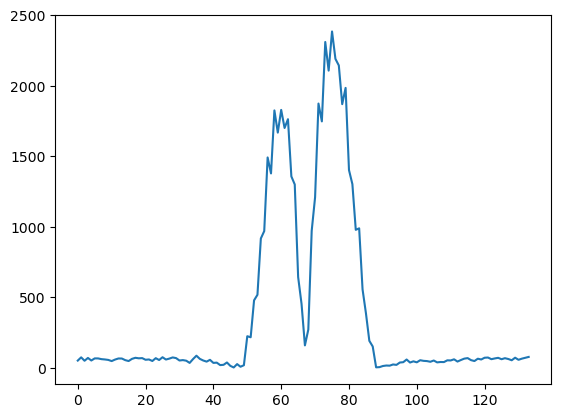

In [9]:
filtered_upper_error = np.asarray(list(filter(lambda x: x > 1, low_histogram_error - combination*len(error))))
plt.plot(filtered_upper_error)

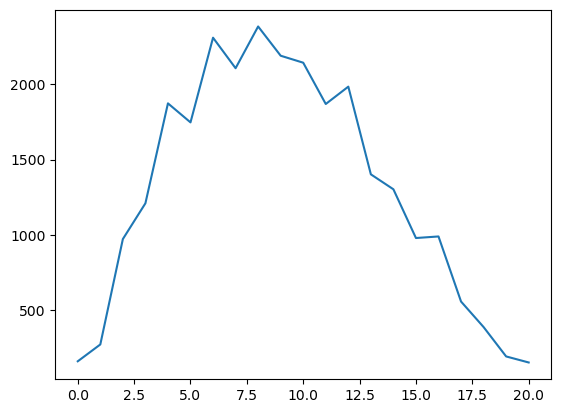

In [10]:
positive_abs_positive_mean = np.asarray(
                                list(
                                    map(lambda x: x[0],
                                        filter(lambda x: x[1] < 128 + std_dev,
                                        filter(lambda x: x[0] > 1 and x[1] > 128,
                                            zip(low_histogram_error - combination*len(error), range(256)))))))

plt.plot(positive_abs_positive_mean)

765.4123469024934
1294.6542214720284


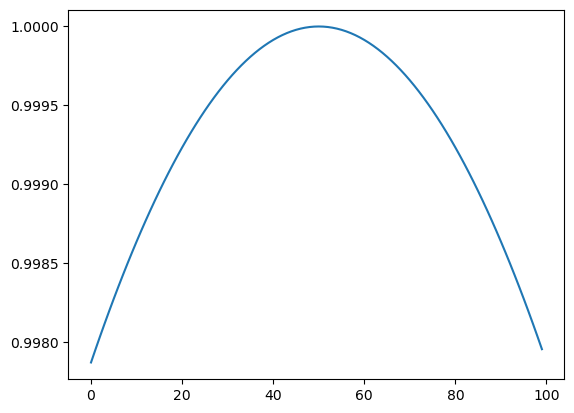

In [11]:
print(np.std(positive_abs_positive_mean))
print(np.mean(positive_abs_positive_mean))
_ = np.arange(np.mean(positive_abs_positive_mean) - 50, np.mean(positive_abs_positive_mean) + 50,1)
plt.plot(norm.pdf(_,np.mean(positive_abs_positive_mean), np.std(positive_abs_positive_mean))/max(norm.pdf(_,np.mean(positive_abs_positive_mean), np.std(positive_abs_positive_mean))))
#plt.plot(positive_abs_positive_mean/max(positive_abs_positive_mean))